### 01 packages

In [1]:
##########################################################################################
##########################################################################################

import matplotlib

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from matplotlib.animation import FuncAnimation

##########################################################################################
##########################################################################################

import numpy as np

import pandas as pd

import random

##########################################################################################
##########################################################################################

import networkx as nx

from shapely.geometry import Point,Polygon

import math

import random

##########################################################################################
##########################################################################################

from scipy.stats import truncnorm

from shapely.geometry import Point,Polygon

from IPython.display import HTML

##########################################################################################
##########################################################################################

import warnings

warnings.filterwarnings("ignore")

/Users/yyan2437/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 02 parameters

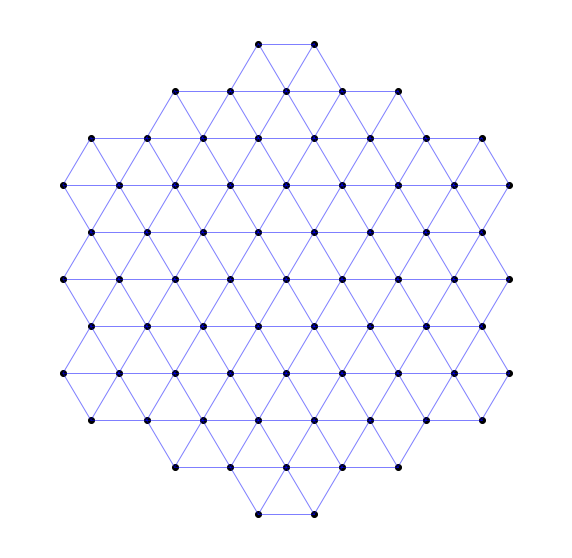

In [2]:
##########################################################################################
##########################################################################################

# Set the lambda parameter for the Poisson distribution

lambda_value = 20

# Number of arrival times to generate

num_arrivals = 1000

##########################################################################################
##########################################################################################

pattern='centralized'#'centralized','uniform'

##########################################################################################
##########################################################################################

Hexagons=np.load('./01network/01/Hexagons.npy')

##########################################################################################
##########################################################################################

Hexagon_nodes=np.load("./01network/01/Hexagon_nodes.npy",allow_pickle=True).item()

Hexagon_edges=np.load("./01network/01/Hexagon_edges.npy",allow_pickle=True).item()

##########################################################################################
##########################################################################################

Nodes=np.load("./01network/01/Nodes.npy")

Edges=np.load("./01network/01/Edges.npy")

##########################################################################################
##########################################################################################

Road_Graph = nx.Graph()

for node in Nodes:
    
    node=tuple(node)
        
    Road_Graph.add_node(node)

for edge in Edges:
    
    node1=tuple(edge[0])
    
    node2=tuple(edge[1])
    
    Road_Graph.add_edge(node1, node2, weight=Point(node1).distance(Point(node2)))

##########################################################################################
##########################################################################################

# parameters of the earliest pick-up

min_1,max_1,mu_1,sigma_1=0.5,2.5,1.5,0.5

##########################################################################################
##########################################################################################

# parameters of the detour ratio

min_2,max_2,mu_2,sigma_2=5,10,7.5,1.5

##########################################################################################
##########################################################################################

speed=10000/60

##########################################################################################
##########################################################################################

figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])
    
for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=1,linestyle='-',alpha=.5)

for node in Road_Graph.nodes:
    
    axs.scatter(node[0], node[1], color='black')

    
# Hide the x and y axes
plt.axis('off')

plt.show()


### 03 user function

In [3]:
##########################################################################################
##########################################################################################

def generate_truncated_gaussian(lower_bound, upper_bound, mean, std, size=1):
    # Calculate the parameters of the corresponding standard normal distribution
    lower_bound_standard = (lower_bound - mean) / std
    upper_bound_standard = (upper_bound - mean) / std

    # Generate random numbers from the truncated Gaussian distribution
    random_numbers = truncnorm.rvs(lower_bound_standard, upper_bound_standard, loc=mean, scale=std, size=size)

    return round(random_numbers[0],1)


### 04 Synthesize

In [4]:
##########################################################################################
##########################################################################################

# 01 arrival time

# Generate random inter-arrival times from the exponential distribution

inter_arrival_times = np.random.exponential(scale=1/lambda_value, size=num_arrivals)

# Generate the continuous arrival times by taking the cumulative sum

arrival_times = np.cumsum(inter_arrival_times)

# Round the arrival times to two decimal places

rounded_arrival_times = np.round(arrival_times, decimals=1)

# Sort the arrival times in ascending order

sorted_arrival_times = np.sort(rounded_arrival_times)

parcel_df=pd.DataFrame(sorted_arrival_times,columns=['t_a'])

parcel_df['parcel_id']=['p'+str(i+1) for i in parcel_df.index]

parcel_df=parcel_df[['parcel_id','t_a']]

##########################################################################################
##########################################################################################

# 03 Pick-ups and Drop-offs

pick_up_s,drop_off_s=list(),list()

pick_up_hexagons,drop_off_hexagons=list(),list()

for i in range(num_arrivals):
    
    travel_dis=0
    
    while travel_dis<=1100:
    
        # Generate a random index to select a row

        pickup_index = np.random.randint(0, len(Hexagons))
        
        dropoff_index = np.random.randint(0, len(Hexagons))

        # Select the randomly chosen row
        
        dropoff_hexagon = Hexagons[dropoff_index]

        # Pick up and Drop off
        
        if pattern=='uniform':
            
            pickup_hexagon = Hexagons[pickup_index]
        
            pick_up_point=random.choice(Hexagon_nodes[pickup_hexagon][:-1])
            
        elif pattern=='centralized':
            
            pickup_hexagon ='H1'
        
            pick_up_point=random.choice(Hexagon_nodes[pickup_hexagon][:-1])

        drop_off_point=random.choice(Hexagon_nodes[dropoff_hexagon][:-1])
        
        travel_dis = nx.shortest_path_length(Road_Graph, source=pick_up_point, target=drop_off_point, weight='weight')

    pick_up_s.append(pick_up_point)
    
    drop_off_s.append(drop_off_point)

    pick_up_hexagons.append(pickup_hexagon)
    
    drop_off_hexagons.append(dropoff_hexagon)

parcel_df['pick_up']=pick_up_s

parcel_df['drop_off']=drop_off_s

parcel_df['h1']=pick_up_hexagons

parcel_df['h2']=drop_off_hexagons

##########################################################################################
##########################################################################################

# 04 latest drop off time

parcel_df['shortest_distance']=parcel_df.apply(lambda x:int(nx.shortest_path_length(Road_Graph, source=x.pick_up, target=x.drop_off, weight='weight')),axis=1)

parcel_df['t_dl']=parcel_df.apply(lambda x:x.t_a+generate_truncated_gaussian(min_2,max_2,mu_2,sigma_2)*(x.shortest_distance/speed),axis=1)

##########################################################################################
##########################################################################################

parcel_df['t_a'] = parcel_df['t_a'].astype(int)

parcel_df['t_dl'] = parcel_df['t_dl'].astype(int)

# parcel_df.to_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')

parcel_df


,parcel_id,t_a,pick_up,drop_off,h1,h2,shortest_distance,t_dl
0,p1,0,"(-500.0, -866.03)","(-500.0, 2598.08)",H1,H17,4000,211
1,p2,0,"(1000.0, 0.0)","(2000.0, -1732.05)",H1,H3,1999,85
2,p3,0,"(500.0, -866.03)","(500.0, 2598.08)",H1,H18,4000,165
3,p4,0,"(500.0, -866.03)","(3500.0, 866.03)",H1,H8,4000,187
4,p5,0,"(-1000.0, 0.0)","(-2000.0, 1732.05)",H1,H6,1999,86
...,...,...,...,...,...,...,...,...
995,p996,48,"(1000.0, 0.0)","(0, -3464.1)",H1,H12,3999,199
996,p997,48,"(1000.0, 0.0)","(-500.0, 2598.08)",H1,H17,3000,170
997,p998,48,"(-1000.0, 0.0)","(1000.0, 1732.05)",H1,H7,2999,170
998,p999,48,"(-500.0, -866.03)","(2500.0, -866.03)",H1,H10,3000,188


### 05 Statistics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


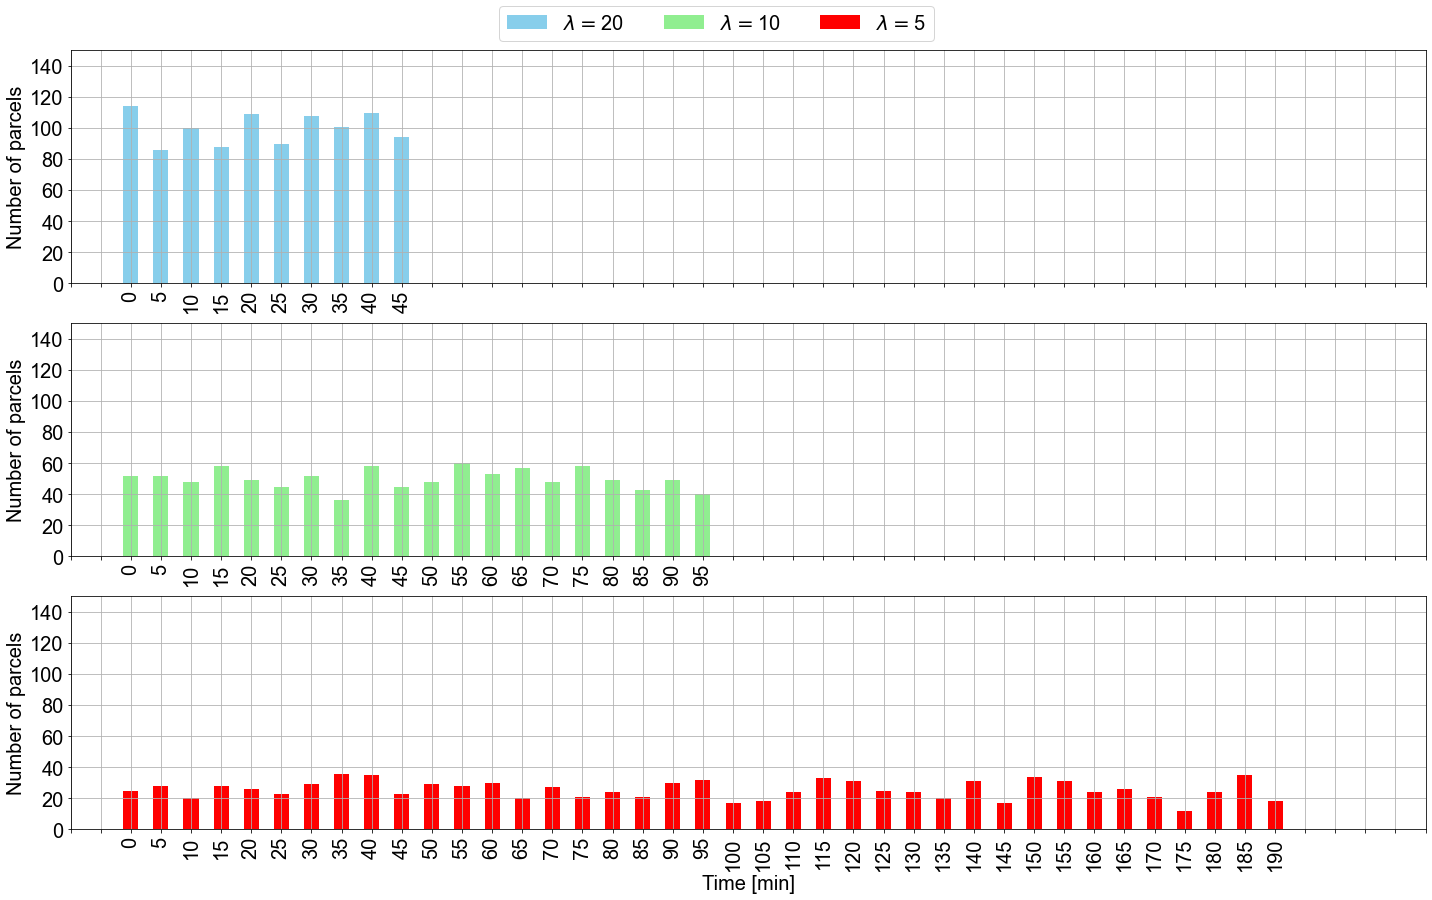

In [5]:
##########################################################################################
##########################################################################################

pattern='uniform'

lambda_values=[20,10,5]

colors=['skyblue','lightgreen','red']

##########################################################################################
##########################################################################################

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(3,1,figsize=(20,12))

##########################################################################################
##########################################################################################
    
for i in range(3):
    
    ##########################################################################################
    ##########################################################################################
 
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Arial') for label in labels]

    ##########################################################################################
    ##########################################################################################
    
    lambda_value=lambda_values[i]
    
    parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')
    
    parcel_df['T']=parcel_df.apply(lambda x:int(x.t_a/5)*5,axis=1)
    
    stat_df=parcel_df.groupby(['T']).count()

    stat_df=stat_df.reset_index()

    stat_df=stat_df[['T','parcel_id']]

    stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})
    
    ##########################################################################################
    ##########################################################################################
    
    stat_df.plot(x='T', y='parcel_num', kind='bar',color=colors[i],ax=axs[i],label='$\\lambda = $'+str(lambda_value),legend=None)
    
    ##########################################################################################
    ##########################################################################################

    xmajorLocator   = MultipleLocator(1)

    axs[i].xaxis.set_major_locator(xmajorLocator)
    
    axs[i].set_ylim([0,150])
    
    axs[i].set_xlim([-2,43])
    
    if i==2:
    
        axs[i].set_xlabel("Time [min]",font_label)
        
    else:
        
        
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Number of parcels',font_label)
    
    axs[i].grid()
    

lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)
    

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.05),prop=font_legend,ncol=3)

plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./07figures/05parcel_temporal_distribution.eps', format='eps', dpi=1000, bbox_inches = 'tight')

##########################################################################################
##########################################################################################

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


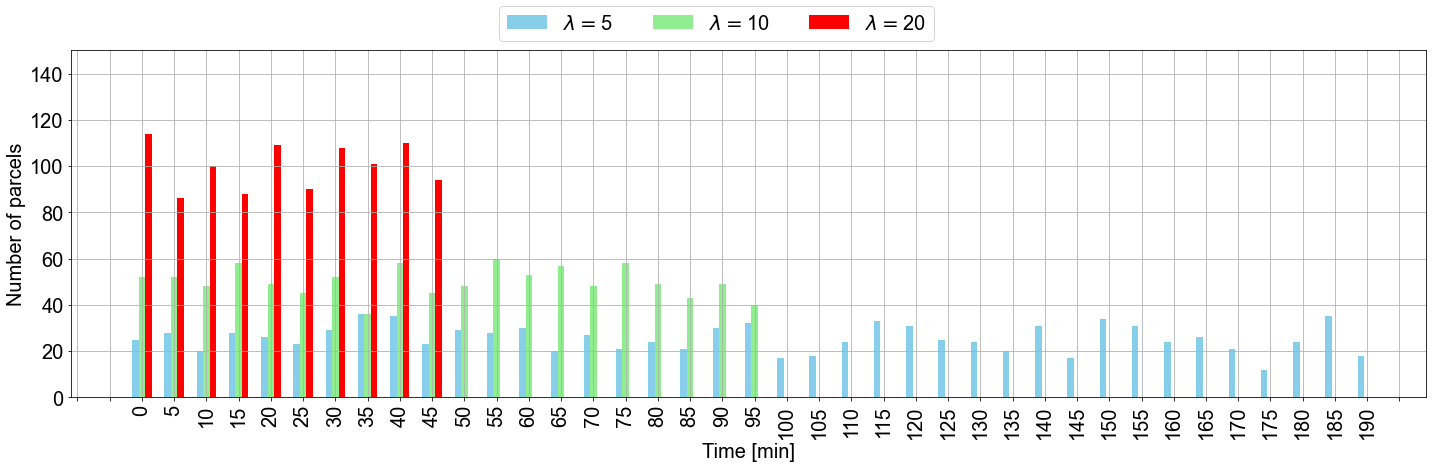

In [6]:
##########################################################################################
##########################################################################################

pattern='uniform'

lambda_values=[5,10,20]

colors=['skyblue','lightgreen','red']

##########################################################################################
##########################################################################################

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(1,1,figsize=(20,6))

##########################################################################################
##########################################################################################
    
labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Arial') for label in labels]

##########################################################################################
##########################################################################################

bar_width = 0.2

##########################################################################################
##########################################################################################
    

for i in range(3):

    ##########################################################################################
    ##########################################################################################
    
    lambda_value=lambda_values[i]
    
    parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')
    
    parcel_df['T']=parcel_df.apply(lambda x:int(x.t_a/5)*5,axis=1)
    
    stat_df=parcel_df.groupby(['T']).count()

    stat_df=stat_df.reset_index()

    stat_df=stat_df[['T','parcel_id']]

    stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})
    
    ##########################################################################################
    ##########################################################################################
    
    index = np.arange(len(stat_df['T']))
    
    plt.bar(index+i*bar_width-bar_width, stat_df['parcel_num'], bar_width,facecolor=colors[i], label='$\\lambda = $'+str(lambda_value))
    
    
    if i==0:
        
        axs.set_xticks(index)

        axs.set_xticklabels(stat_df['T'].to_list(), rotation=90)

    

##########################################################################################
##########################################################################################

xmajorLocator   = MultipleLocator(1)

axs.xaxis.set_major_locator(xmajorLocator)

axs.set_ylim([0,150])

# axs.set_xlim([-2,43])

axs.set_xlabel("Time [min]",font_label)

axs.set_ylabel('Number of parcels',font_label)

axs.grid()

##########################################################################################
##########################################################################################
    

lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

##########################################################################################
##########################################################################################

##########################################################################################
##########################################################################################

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.1),prop=font_legend,ncol=3)

plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./07figures/05parcel_temporal_distribution.eps', format='eps', dpi=1000, bbox_inches = 'tight')

##########################################################################################
##########################################################################################

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


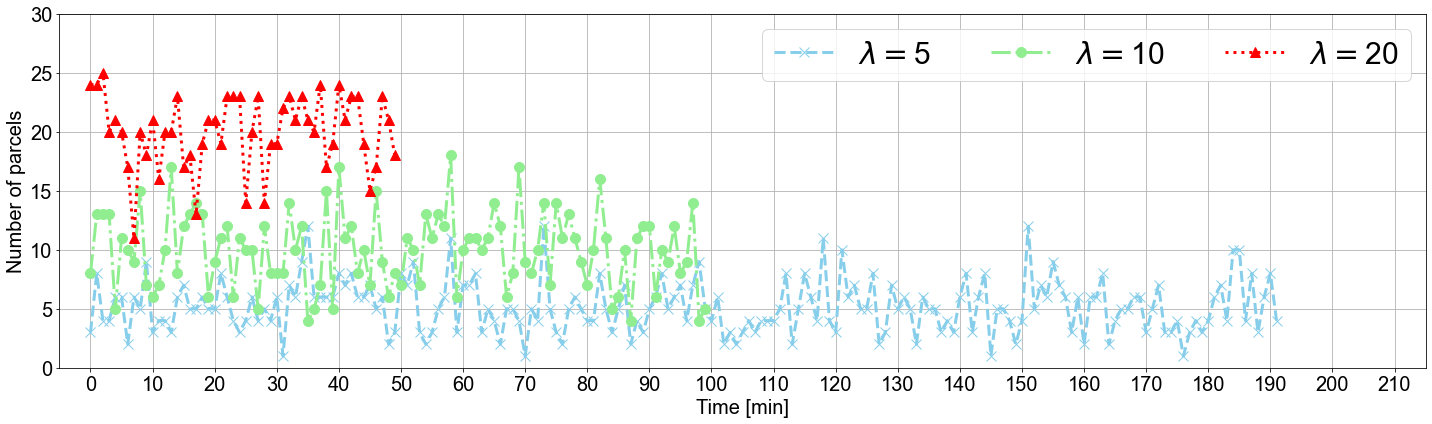

In [7]:
##########################################################################################
##########################################################################################

pattern='uniform'

lambda_values=[5,10,20]

colors=['skyblue','lightgreen','red']

##########################################################################################
##########################################################################################

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 30}

figure, axs = plt.subplots(1,1,figsize=(20,6))

##########################################################################################
##########################################################################################
    
labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Arial') for label in labels]

##########################################################################################
##########################################################################################

markers=['x','o','^']

linestyles=['--','-.',':']

##########################################################################################
##########################################################################################
    

for i in range(3):

    ##########################################################################################
    ##########################################################################################
    
    lambda_value=lambda_values[i]
    
    parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')
    
#     parcel_df['T']=parcel_df.apply(lambda x:int(x.t_a/5)*5,axis=1)
    
    stat_df=parcel_df.groupby(['t_a']).count()

    stat_df=stat_df.reset_index()
    
    stat_df=stat_df.rename(columns={"t_a":"T"})

    stat_df=stat_df[['T','parcel_id']]

    stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})
    
    ##########################################################################################
    ##########################################################################################
    
    index = np.arange(len(stat_df['T']))
    
    plt.plot(index, stat_df['parcel_num'], linewidth=3,color=colors[i],\
             label='$\\lambda = $'+str(lambda_value),\
             marker=markers[i],markersize=10,linestyle=linestyles[i])
    
    

##########################################################################################
##########################################################################################

xmajorLocator   = MultipleLocator(10)

axs.xaxis.set_major_locator(xmajorLocator)

axs.set_ylim([0,30])

axs.set_xlim([-5,215])

axs.set_xlabel("Time [min]",font_label)

axs.set_ylabel('Number of parcels',font_label)

axs.grid()

##########################################################################################
##########################################################################################


##########################################################################################
##########################################################################################

axs.legend(loc ='upper right',prop=font_legend,ncol=3)

plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./07figures/05parcel_temporal_distribution.eps', format='eps', dpi=1000, bbox_inches = 'tight')

##########################################################################################
##########################################################################################

plt.show()

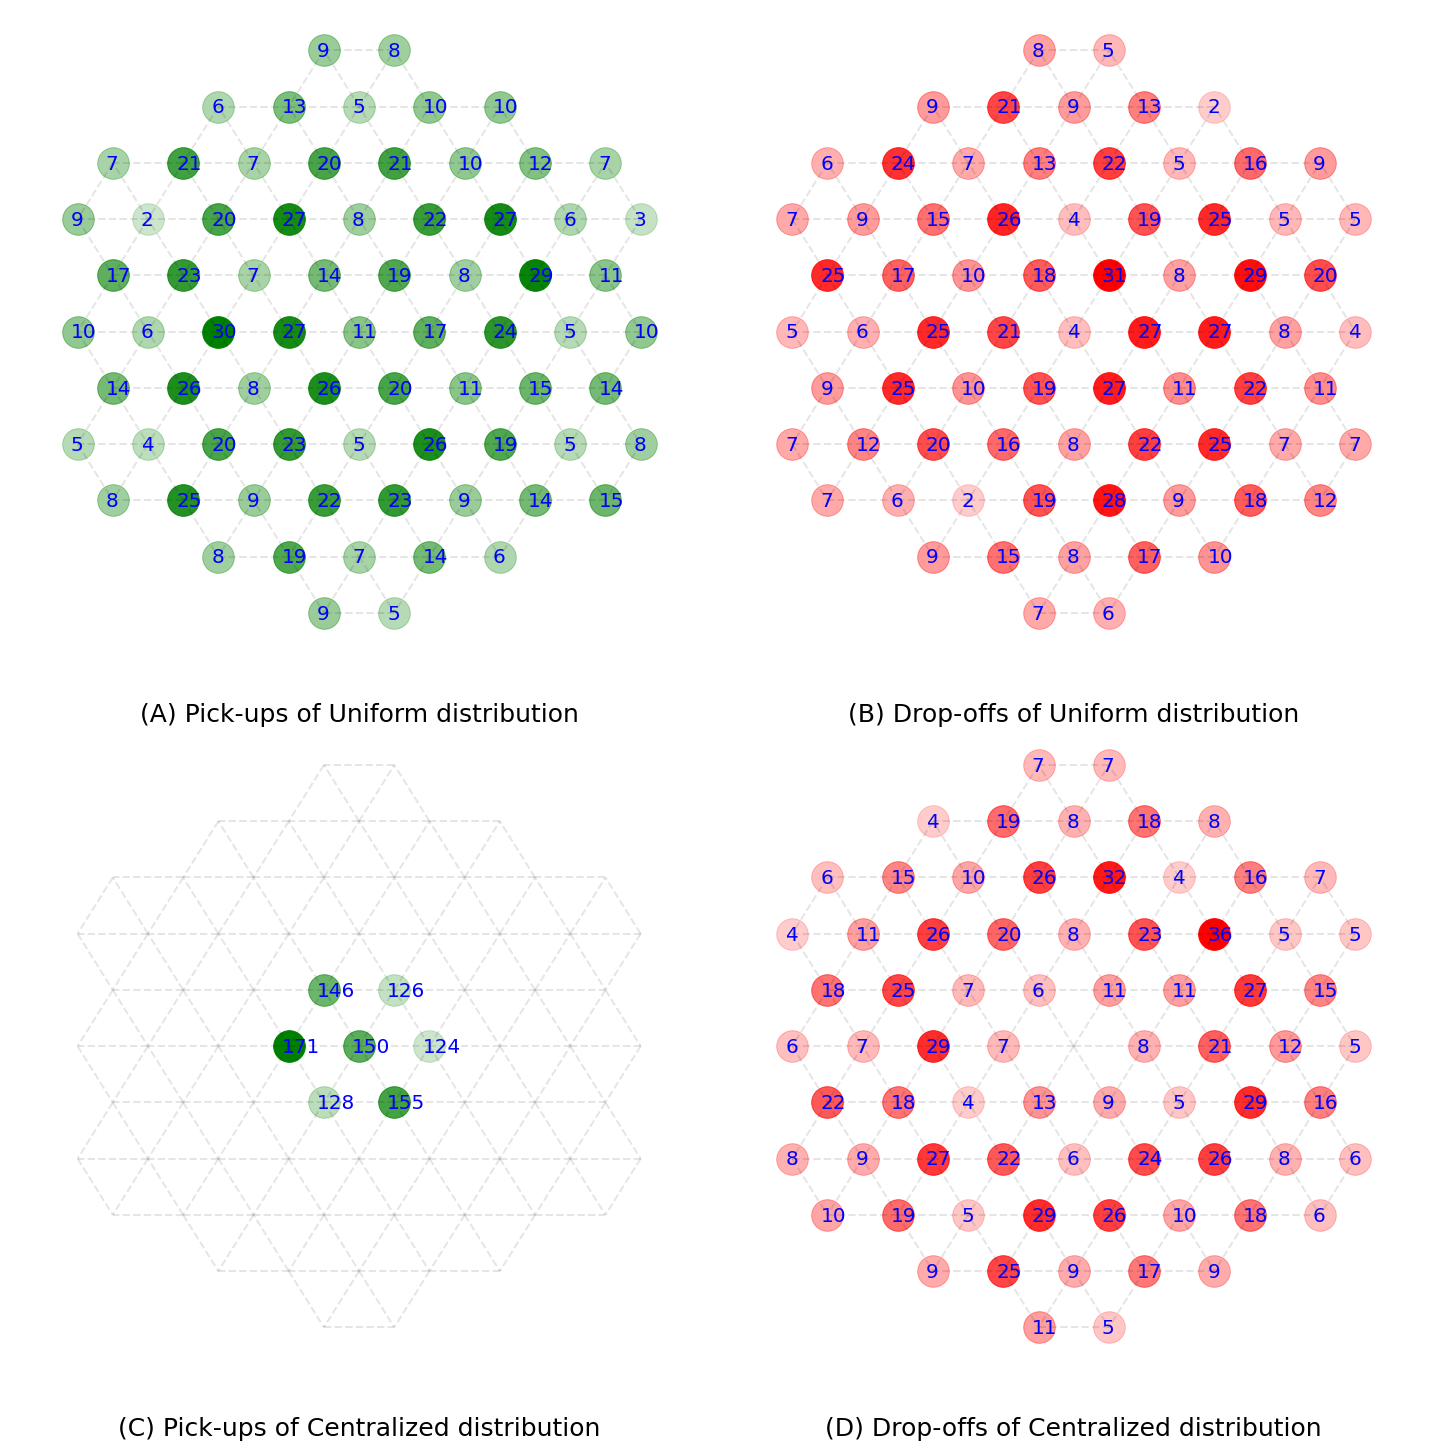

In [8]:
##########################################################################################
##########################################################################################

lambda_value=10

patterns=['uniform','centralized']

##########################################################################################
##########################################################################################

x_labels=[['(A) Pick-ups of Uniform distribution','(B) Drop-offs of Uniform distribution'],\
          ['(C) Pick-ups of Centralized distribution','(D) Drop-offs of Centralized distribution']]

##########################################################################################
##########################################################################################

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(2,2,figsize=(20,20))

##########################################################################################
##########################################################################################
    
for i in range(2):
    
    pattern=patterns[i]
    
    parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')
    
    parcel_df['pick_up']=parcel_df.apply(lambda x:tuple([float(y) for y in x.pick_up.replace("(","").replace(")","").split(',')]),axis=1)
    
    parcel_df['drop_off']=parcel_df.apply(lambda x:tuple([float(y) for y in x.drop_off.replace("(","").replace(")","").split(',')]),axis=1)
    
    for j in range(2):
    
        ##########################################################################################
        ##########################################################################################

        axs[i][j].set_xlim([-5000,5000])

        axs[i][j].set_ylim([-5000,5000])
        
        axs[i][j].axis('off')

        ##########################################################################################
        ##########################################################################################
        
        for edge in Road_Graph.edges:
    
            axs[i][j].plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='black',linewidth=2,linestyle='--',alpha=.1)
        
        ##########################################################################################
        ##########################################################################################
        
        if j==0:
            
            stat_df=parcel_df.groupby(['pick_up']).count()

            stat_df=stat_df.reset_index()

            stat_df=stat_df[['pick_up','parcel_id']]

            stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})

            stat_df['ratio']=stat_df.apply(lambda x:(x.parcel_num-stat_df.parcel_num.min())/(stat_df.parcel_num.max()-stat_df.parcel_num.min()),axis=1)
            
            stat_df['ratio']=stat_df.apply(lambda x:x.ratio*0.8+0.2,axis=1)
            
            for idx,row in stat_df.iterrows():

                axs[i][j].scatter(row.pick_up[0], row.pick_up[1], color='green',s=1000,alpha=row.ratio)
                
                axs[i][j].text(row.pick_up[0]-100, row.pick_up[1]-100,str(row.parcel_num),fontsize=20, color='blue')
                
        elif j==1:
            
            stat_df=parcel_df.groupby(['drop_off']).count()

            stat_df=stat_df.reset_index()

            stat_df=stat_df[['drop_off','parcel_id']]

            stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})

            stat_df['ratio']=stat_df.apply(lambda x:(x.parcel_num-stat_df.parcel_num.min())/(stat_df.parcel_num.max()-stat_df.parcel_num.min()),axis=1)
            
            stat_df['ratio']=stat_df.apply(lambda x:x.ratio*0.8+0.2,axis=1)
            
            for idx,row in stat_df.iterrows():

                axs[i][j].scatter(row.drop_off[0], row.drop_off[1], color='red',s=1000,alpha=row.ratio)
                
                axs[i][j].text(row.drop_off[0]-100, row.drop_off[1]-100,str(row.parcel_num),fontsize=20, color='blue')

        ##########################################################################################
        ##########################################################################################
        
        
        axs[i][j].text(0.5, -0.1, x_labels[i][j], ha='center', transform=axs[i][j].transAxes,fontsize=25, fontstyle='normal')

    
plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./07figures/06parcel_spatial_distribution.png',  bbox_inches = 'tight')

# current_fig.savefig('./07figures/06parcel_spatial_distribution.eps', format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()

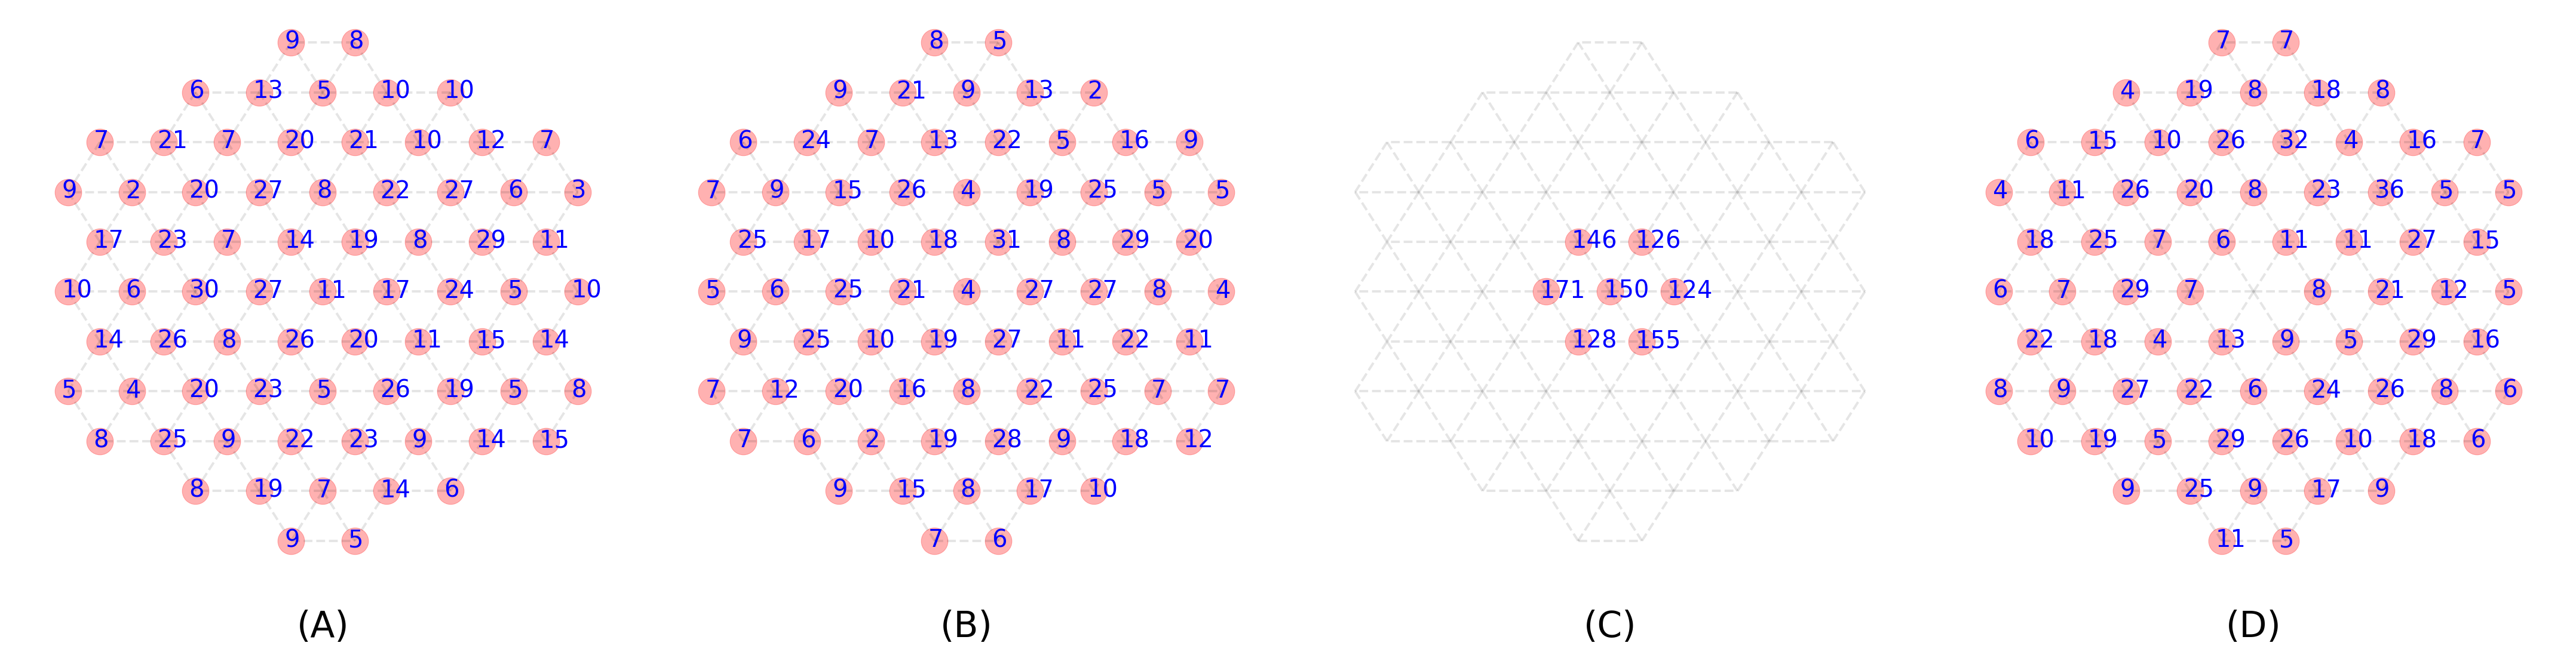

In [10]:
##########################################################################################
##########################################################################################

lambda_value=10

patterns=['uniform','centralized']

##########################################################################################
##########################################################################################

# x_labels=[['(A) Pick-ups of \nUniform distribution','(B) Drop-offs of \nUniform distribution'],\
#           ['(C) Pick-ups of \nMono-centric distribution','(D) Drop-offs of \nMono-centric distribution']]

x_labels=[['(A)','(B)'],\
          ['(C)','(D)']]


##########################################################################################
##########################################################################################

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, axs = plt.subplots(1,4,figsize=(60,15))

##########################################################################################
##########################################################################################

figure_idx=0
    
for i in range(2):
    
    pattern=patterns[i]
    
    parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')
    
    parcel_df['pick_up']=parcel_df.apply(lambda x:tuple([float(y) for y in x.pick_up.replace("(","").replace(")","").split(',')]),axis=1)
    
    parcel_df['drop_off']=parcel_df.apply(lambda x:tuple([float(y) for y in x.drop_off.replace("(","").replace(")","").split(',')]),axis=1)
    
    for j in range(2):
    
        ##########################################################################################
        ##########################################################################################

        axs[figure_idx].set_xlim([-5000,5000])

        axs[figure_idx].set_ylim([-5000,5000])
        
        axs[figure_idx].axis('off')

        ##########################################################################################
        ##########################################################################################
        
        for edge in Road_Graph.edges:
    
            axs[figure_idx].plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='black',linewidth=4,linestyle='--',alpha=.1)
        
        ##########################################################################################
        ##########################################################################################
        
        if j==0:
            
            stat_df=parcel_df.groupby(['pick_up']).count()

            stat_df=stat_df.reset_index()

            stat_df=stat_df[['pick_up','parcel_id']]

            stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})

            stat_df['ratio']=stat_df.apply(lambda x:(x.parcel_num-stat_df.parcel_num.min())/(stat_df.parcel_num.max()-stat_df.parcel_num.min()),axis=1)
            
            stat_df['ratio']=stat_df.apply(lambda x:x.ratio*0.8+0.2,axis=1)
            
            for idx,row in stat_df.iterrows():

                axs[figure_idx].scatter(row.pick_up[0], row.pick_up[1], color='red',s=2000,alpha=0.3)
                
                axs[figure_idx].text(row.pick_up[0]-100, row.pick_up[1]-100,str(row.parcel_num),fontsize=40, color='blue')
                
        elif j==1:
            
            stat_df=parcel_df.groupby(['drop_off']).count()

            stat_df=stat_df.reset_index()

            stat_df=stat_df[['drop_off','parcel_id']]

            stat_df=stat_df.rename(columns={"parcel_id":"parcel_num"})

            stat_df['ratio']=stat_df.apply(lambda x:(x.parcel_num-stat_df.parcel_num.min())/(stat_df.parcel_num.max()-stat_df.parcel_num.min()),axis=1)
            
            stat_df['ratio']=stat_df.apply(lambda x:x.ratio*0.8+0.2,axis=1)
            
            for idx,row in stat_df.iterrows():

                axs[figure_idx].scatter(row.drop_off[0], row.drop_off[1], color='red',s=2000,alpha=0.3)
                
                axs[figure_idx].text(row.drop_off[0]-100, row.drop_off[1]-100,str(row.parcel_num),fontsize=40, color='blue')

        ##########################################################################################
        ##########################################################################################

        axs[figure_idx].text(0.5, -0.1, x_labels[i][j], ha='center', transform=axs[figure_idx].transAxes,fontsize=60, fontstyle='normal')

        figure_idx+=1


    
plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./07figures/06parcel_spatial_distribution.png',  bbox_inches = 'tight')

# current_fig.savefig('./07figures/06parcel_spatial_distribution.eps', format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()